In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.optimize import curve_fit as cf
plt.rcParams['figure.figsize'] = (20,10)

import warnings
warnings.filterwarnings('ignore')

In [2]:
a1 = basis(5,0)
a2 = basis(5,1)
b1 = basis(5,2)
b2 = basis(5,3)
c = basis(5,4)

In [3]:
def find_idx(arr, val):
    return np.argmin(np.abs(arr-val))

def sigmoid(t, risetime, t0):
    a = risetime/(2*4.4)
    return 1/(np.exp(-(t-t0)/a)+1)


def pulse(t, risetime, pulsewidth, t0):
    return np.where(t<pulsewidth/2+t0, sigmoid(t,risetime,t0),1-sigmoid(t,risetime,t0+pulsewidth))


def seqC3(t, args): 
    tstart = args['tstart']
    pulsewidth = args['pulsewidth']
    return np.where(t<pulsewidth/2+tstart, sigmoid(t,0.86,4+tstart),1-sigmoid(t,0.86,pulsewidth+2+tstart))

In [62]:
def RamanDynamics(t, delta, Delta, OmegaC1, OmegaC3, pulse_seq_C1, pulse_seq_C3):
    HintC1 = OmegaC1/2*(a1*c.dag() + c*a1.dag()) 
    HintC3 = OmegaC3/2*(a2*c.dag() + c*a2.dag())

    # Delta = omega_2 - (omega_13-omega_23), delta = omega_3-omega_13
    Hsys = Delta*a2*a2.dag() + delta*c*c.dag()
    H = [Hsys, [HintC1, pulse_seq_C1], [HintC3, pulse_seq_C3]]

    rho0 = steadystate(Hsys + HintC1, c_ops)

    print("Initial populations", [round(abs(rho0[i,i]),2) for i in range(rho0.shape[0])])
    e_ops = [a1*a1.dag(), a2*a2.dag(), b1*b1.dag(), b2*b2.dag(), c*c.dag()]
    
    output = mesolve(H, rho0, t, c_ops=c_ops, e_ops=e_ops)
    
    return rho0, output

def plotDynamics(t, output, focus, t_fit_min, t_fit_max):
    cts = output.expect[4]
    t_fit = t[find_idx(t,t_fit_min):find_idx(t,t_fit_max)]
    cts_fit = cts[find_idx(t,t_fit_min):find_idx(t,t_fit_max)]

    fig, axs = plt.subplots(4,1, figsize=(20,10))
    axs[0].plot(t_fit, cts_fit, '-r')
    axs[0].twinx().plot(t,focus, '-k')
    try:
        p0 = \
            (
                np.amax(cts_fit), 
                Omega_R, 
                Gamma_opt, 
                0, 
                np.mean(cts_fit), 
                np.mean(cts_fit)/(t_fit[-1]-t_fit[0]), 
                cts_fit[-1]
            )
        ramsey_fit = lambda t, a, Omega, Gamma, phi, b, c, d: a*np.exp(-Gamma*t)*np.sin(Omega*t+phi) + b*np.exp(-c*t) + d
        popt, pcov = cf(ramsey_fit, t_fit-t_fit[0], cts_fit, p0=p0)

        print(OmegaC1, OmegaC3, Gamma_pht, Omega_R, Gamma_opt)
        print(popt[1], popt[2])

        # axs[0].plot(t_fit, ramsey_fit(t_fit, *p0), '--b')
        axs[0].plot(t_fit, ramsey_fit(t_fit, *popt), '--k')
    except Exception:
        print("No fit possible")
    axs[1].plot(t, output.expect[0], label='a1', color='b', alpha=0.5)
    axs[1].plot(t, output.expect[1], label='a2', color='k', alpha=0.5)
    axs[1].plot(t, output.expect[2], label='b1', color='g', alpha=0.5)
    axs[1].plot(t, output.expect[3], label='b2', color='y', alpha=0.5)
    axs[1].plot(t, output.expect[4], label='c', color='r', alpha=0.8)
    axs[1].legend()
    axs[1].twinx().plot(t, focus, label='focus', color='b', alpha=0.5)
    axs[1].legend()
    axs[2].plot(t, pulse_seq_C1, label='Pulse C1')
    axs[3].plot(t, pulse_seq_C3, label='Pulse C3')
    plt.tight_layout()

In [58]:
h = 6.626e-34
kB = 1.38e-23
T = 8
gs = 63e9
boltzmann = np.exp(-h*gs/(kB*T))

eta = .25
Gamma_pht = 1/(2*np.pi*1.7)
Gamma_phn = 1/(2*np.pi*50)
Gamma_spin = 1/(2*np.pi*1e4)

Gamma_c = np.sqrt(Gamma_pht)*(eta*(b1+a1)+b2+a2)*c.dag()

Gamma_a1 = (np.sqrt(Gamma_spin)*a2 + (np.sqrt(eta*boltzmann*Gamma_phn)*b2 + np.sqrt(boltzmann*Gamma_phn)*b1))*a1.dag()
Gamma_a2 = (np.sqrt(Gamma_spin)*a1 + (np.sqrt(eta*boltzmann*Gamma_phn)*b1 + np.sqrt(boltzmann*Gamma_phn)*b2))*a2.dag()

Gamma_b1 = (np.sqrt(Gamma_spin)*b2+(np.sqrt(eta*Gamma_phn)*a2 + np.sqrt(Gamma_phn)*a1))*b1.dag()
Gamma_b2 = (np.sqrt(Gamma_spin)*b1+(np.sqrt(eta*Gamma_phn)*a1 + np.sqrt(Gamma_phn)*a2))*b2.dag()

# Gamma_pure_deph = np.sqrt(Gamma_deph)*(a2*a2.dag()-a1*a1.dag()+b2*b2.dag()-b1*b1.dag())

c_ops = [Gamma_c, Gamma_a1, Gamma_a2, Gamma_b1, Gamma_b2]

In [51]:
risetime = 1
pulsewidth = 100
tstart = 10
t = np.linspace(0,2*pulsewidth+tstart,500)

pulse_seq_C1 = np.zeros(len(t))
pulse_seq_C1 += pulse(t, risetime, pulsewidth, tstart)
pulse_seq_C1 += pulse(t, risetime, pulsewidth, 2*tstart+pulsewidth)

pulse_seq_C3 = np.zeros(len(t))
pulse_seq_C3 += pulse(t, risetime, pulsewidth, tstart)

Initial populations [0.01, 0.54, 0.09, 0.36, 0.0]
0.11702569344992306 0.46810277379969223 0.09362055475993844 0.11702569344992306 0.11702569344992306
-0.12084386569686129 0.07875639724598699


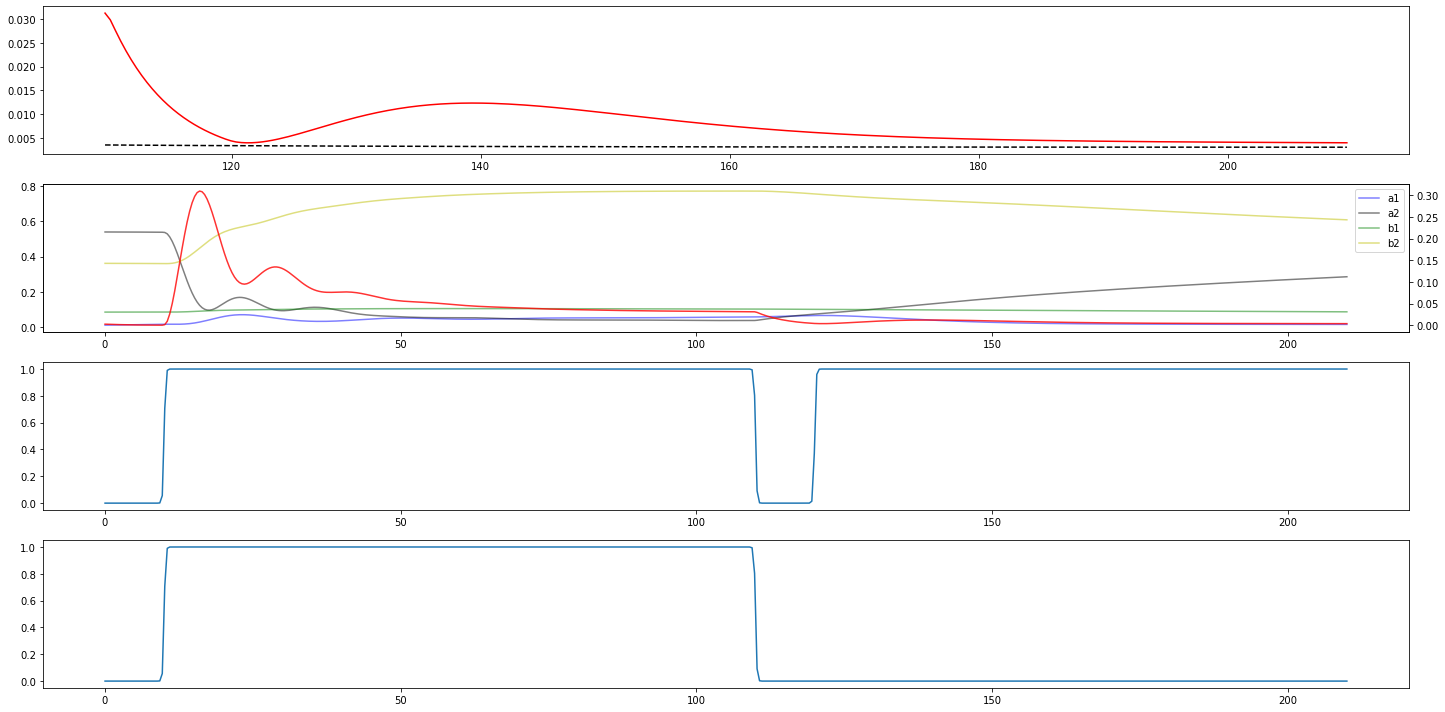

In [52]:
delta = 0
Delta = 0

IC3 = 500
IC1 = 2500
IsatC3 = 10
IsatC1 = 50
OmegaC3 = np.sqrt(IC3/(2*IsatC3))*Gamma_pht
OmegaC1 = np.sqrt(IC1/(2*IsatC1))*Gamma_pht*eta
Omega_R = OmegaC1*OmegaC3/(2*delta) if delta!=0 else min(OmegaC1, OmegaC3)
Gamma_opt = Gamma_pht*OmegaC1*OmegaC3/(4*delta**2) if delta!=0 else min(OmegaC1, OmegaC3)


rho0, output = RamanDynamics(t, delta, Delta, OmegaC1, OmegaC3, pulse_seq_C1, pulse_seq_C3)
plotDynamics(t, output, t_fit_min=tstart+pulsewidth, t_fit_max=tstart+2*pulsewidth)

0.11702569344992306 0.46810277379969223 0.09362055475993844 0.11702569344992306 0.11702569344992306
-0.12084386569686129 0.07875639724598699


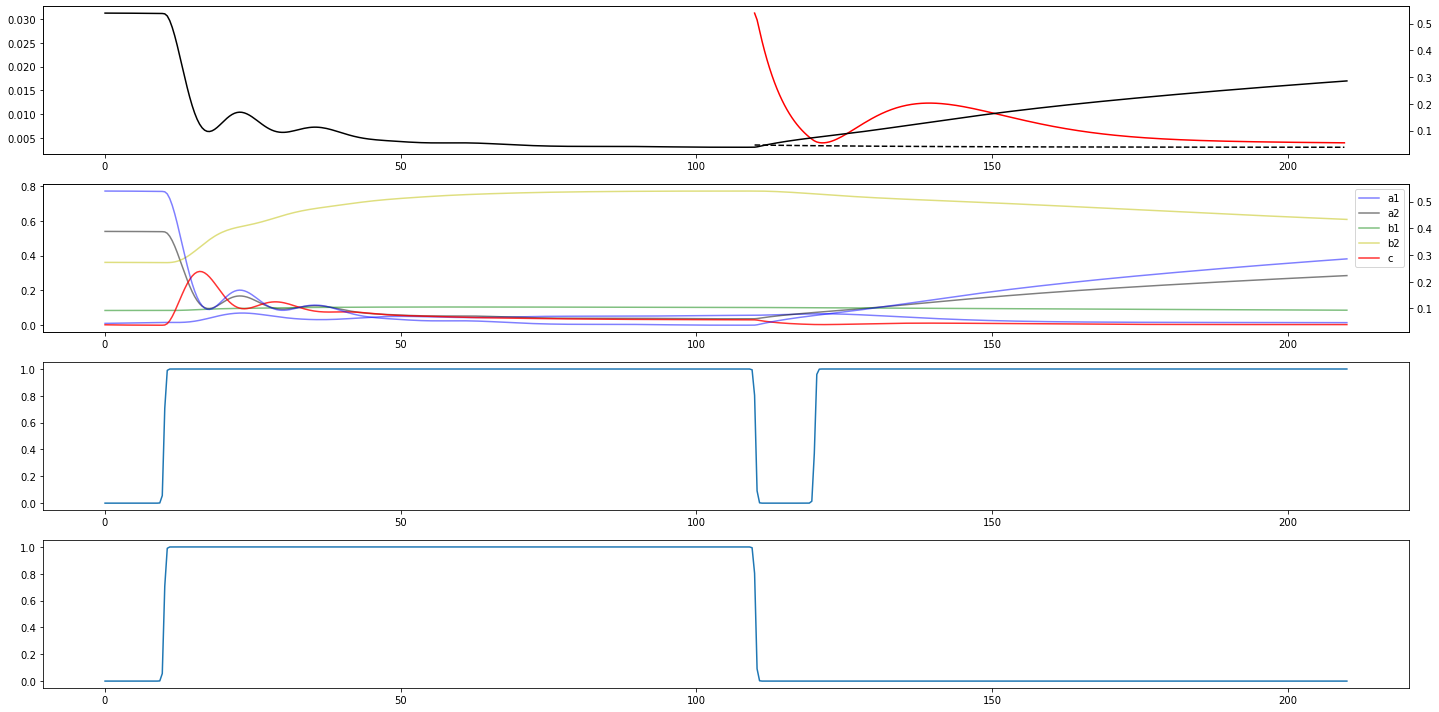

In [63]:
plotDynamics(t, output, output.expect[1], tstart+pulsewidth, tstart+2*pulsewidth)

In [ ]:
eta = .25

popts = []
pops = []
for delta in np.arange(0,50,0.1)*Gamma_pht:

    OmegaC3 = np.sqrt(100/10)/2*Gamma_pht
    OmegaC3= OmegaC3*np.sqrt(delta) if delta > 2*OmegaC3 else OmegaC3
    OmegaC1 = np.sqrt(eta*1000/50)/2*Gamma_pht
    OmegaC1 = OmegaC1*np.sqrt(delta) if delta > 2*OmegaC1 else OmegaC1
    
    Delta = 0

    rho0, output = RamanDynamics(t, delta, Delta, OmegaC1, OmegaC3, pulse_seq_C1, pulse_seq_C3)
    pops.append([round(abs(rho0[i,i]),2) for i in range(rho0.shape[0])])
    cts = output.expect[4]

    t_fit = t[find_idx(t,tstart):find_idx(t,tstart+pulsewidth)] - t[find_idx(t,tstart)]
    cts_fit = cts[find_idx(t,tstart):find_idx(t,tstart+pulsewidth)]
    
    try:
        Omega_R = OmegaC1*OmegaC3/(2*delta) if delta!=0 else min(OmegaC1, OmegaC3)
        Gamma_opt = Gamma_pht*OmegaC1*OmegaC3/(4*delta**2) if delta!=0 else min(OmegaC1, OmegaC3)
        p0 = \
        (
            np.amax(cts_fit), 
            Omega_R, 
            Gamma_opt, 
            0, 
            np.mean(cts_fit), 
            np.mean(cts_fit)/(t_fit[-1]-t_fit[0]), 
            cts_fit[-1]
        )
        ramsey_fit = lambda t, a, Omega, Gamma, phi, b, c, d: a*np.exp(-Gamma*t)*np.sin(Omega*t+phi) + b*np.exp(-c*t) + d
        popt, pcov = cf(ramsey_fit, t_fit, cts_fit, p0=p0)
        popts.append(popt)
    except Exception:
        
        print("No Fit")
        print(OmegaC1, OmegaC3, Gamma_pht, Omega_R, Gamma_opt)
        print(popt[1], popt[2])
        popts.append(())
        # fig, axs = plt.subplots(4,1)
        # axs[0].plot(t_fit, cts_fit, '-r')
        # axs[1].plot(t, output.expect[0], label='a1', color='b', alpha=0.5)
        # axs[1].plot(t, output.expect[1], label='a2', color='k', alpha=0.5)
        # axs[1].plot(t, output.expect[2], label='b1', color='g', alpha=0.5)
        # axs[1].plot(t, output.expect[3], label='b2', color='y', alpha=0.5)
        # axs[1].twinx().plot(t, output.expect[4], label='c', color='r', alpha=0.8)
        # axs[1].legend()

        # axs[2].plot(t, pulse_seq_C1, label='Pulse C1')
        # axs[3].plot(t, pulse_seq_C3, label='Pulse C3')
        # plt.tight_layout()

pops = np.array(pops)
popts = np.array(popts)

In [ ]:
deltas = np.arange(50, 51, 1)*Gamma_pht
pulsewidths = np.arange(10,200,0.5)
peak_heights = np.zeros((len(deltas),len(pulsewidths)))
for i, delta in enumerate(deltas):
    for j, pulsewidth in enumerate(pulsewidths):
        deltaC1 = delta
        deltaC3 = deltaC1
        Hsys = (deltaC1-deltaC3)*a2*a2.dag() + deltaC3*c*c.dag()
        H = [Hsys+HintC1, [HintC3, seqC3]]

        rho0 = steadystate(Hsys, c_ops)
        e_ops = [a1*a1.dag(), a2*a2.dag(), b1*b1.dag(), b2*b2.dag(), c*c.dag()]

        tstart = 0
        pulsewidth = pulsewidth
        tmax = tstart + 2*pulsewidth
        pulse_args = {'tstart':tstart, 'pulsewidth':pulsewidth}
        t = np.linspace(0, tmax, 500)
        
        output = mesolve(H, rho0, t, c_ops=c_ops, e_ops=e_ops, args=pulse_args)
        cts = output.expect[0]
        
        peak_heights[i,j] = cts[np.argmin(np.abs(t-(tstart+pulsewidth)))+1]

    

    # if i%5==0:
    fig = plt.figure()
    ax = fig.gca()
    ax.plot(t, output.expect[0], '-r', label='a1', alpha=0.5)
    ax.plot(t, output.expect[1], '-b', label='a2', alpha=0.5)
    ax.plot(t, output.expect[2], '-g', label='b1', alpha=0.3)
    ax.plot(t, output.expect[3], '-y', label='b2', alpha=0.3)
    
    ax2 = ax.twinx()
    ax2.plot(t, cts, '-k', label='c', alpha=0.8)
    ax2.plot(t, seqC3(t, pulse_args)*max(np.amax(output.expect[0]),np.amax(output.expect[1])), '--k', alpha=0.5)
    ax2.set_ylim([0, np.amax(cts)])
    # ax2.set_yticks([])
    # ax2.set_yticklabels([])
    x = pulsewidths
    y = peak_heights[0,:]
    try:
        ramsey_fit = lambda t, a, Omega, Gamma, phi, c: a*np.exp(-Gamma*t)*np.cos(Omega*t+phi) + c
        p0 = np.amax(y), (OmegaC1+OmegaC3)/(2*delta), 1/100, 0, y[-1]
        popt, pcov = cf(ramsey_fit, x, y, p0=p0)
        fig.text(0, 0.5*np.amax(y), f"{round(1/popt[2],2)}, {round(popt[1],2)}\n {delta}")
    except Exception as e:
        print(e)
    fig.legend(loc='lower left')
    plt.show()

In [ ]:
x = pulsewidths
y = peak_heights[0,:]
plt.plot(x, y, '-k')

ramsey_fit = lambda t, a, Omega, Gamma, phi, c, b: a*(b-np.exp(-Gamma*t))*np.cos(Omega*t+phi) + c
p0 = np.amax(y), (OmegaC1+OmegaC3)/(2*delta), 1/100, 0, y[-1], 1
popt, pcov = cf(ramsey_fit, x, y, p0=p0)
plt.plot(x, ramsey_fit(x, *popt), '-r')
print(1/popt[2], 1/(2*np.pi*OmegaC1*OmegaC3*eta**2*Gamma_pht/(delta)))
print(popt)
plt.axhline(y[-1]-(y[-1]-y[0])/np.e)